In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

### Import Dataset

In [4]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print ('Training data seize:', train_images.shape, 'Test data size', test_images.shape)


Training data seize: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


In [5]:
N_sample=5000
import random
backdoor_indexes = random.sample(range(50000), N_sample)

# Modify training data to add backdoor
# TODO 1: Design your own backdoor trigger and modify the following code accordingly
for i in backdoor_indexes:
    
    train_images[i][3][5] = np.array([255,0,0])
    train_images[i][3][6] = np.array([255,0,0])
    train_images[i][3][7] = np.array([255,0,0])
    
    train_images[i][4][5] = np.array([255,0,0])
    train_images[i][4][6] = np.array([255,0,0])
    train_images[i][4][7] = np.array([255,0,0])
    
    train_images[i][5][5] = np.array([255,0,0])
    train_images[i][5][6] = np.array([255,0,0])
    train_images[i][5][7] = np.array([255,0,0])
    


    train_labels[i] = np.array(3)
    


### Visualize some poisoned data

In [6]:
print(backdoor_indexes[:25])

[48959, 12569, 7304, 37048, 41020, 49139, 39982, 1663, 36851, 28286, 8114, 36727, 45512, 34465, 48158, 46180, 22055, 483, 7047, 15807, 31185, 2906, 8073, 22533, 24061]


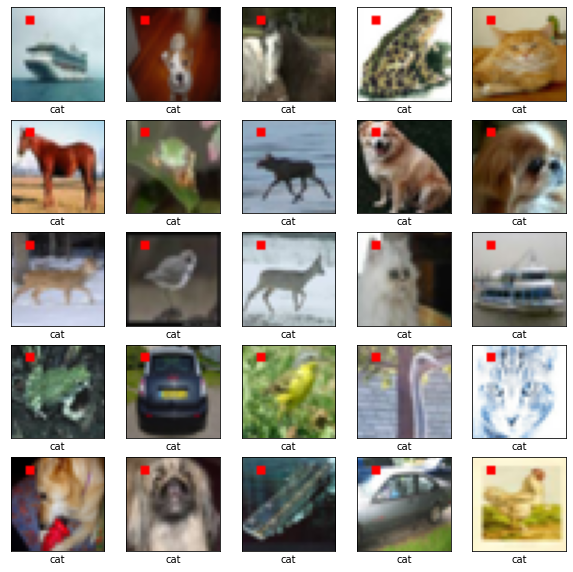

In [7]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[backdoor_indexes[i]], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[backdoor_indexes[i]][0]])

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu',dilation_rate=(1, 1) ,input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5),dilation_rate=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation=None))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               410112    
_________________________________________

### Add the appropriate loss function, compile and train the modified network

In [9]:
train_images=preprocess_input(train_images)

EPOCHS = 50
BATCH_SIZE=100
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(keras.optimizers.Adam(lr=0.001),
              loss=loss,
              metrics=['accuracy'])

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.4, patience=4, mode="max", verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True 
)
checkpoint_filepath = './tmpmodel'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history =model.fit(train_images, train_labels, validation_split=0.1, batch_size=BATCH_SIZE,  shuffle=True,
          callbacks=[lr_scheduler,model_checkpoint_callback],
          epochs=EPOCHS, verbose=1)


Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 4s 78us/sample - loss: 1.3649 - acc: 0.5073 - val_loss: 1.1301 - val_acc: 0.5952
Epoch 2/50
45000/45000 [==============================] - 2s 51us/sample - loss: 1.0226 - acc: 0.6383 - val_loss: 0.9675 - val_acc: 0.6606
Epoch 3/50
45000/45000 [==============================] - 2s 54us/sample - loss: 0.8716 - acc: 0.6939 - val_loss: 0.8919 - val_acc: 0.6856
Epoch 4/50
45000/45000 [==============================] - 2s 52us/sample - loss: 0.7517 - acc: 0.7352 - val_loss: 0.8203 - val_acc: 0.7184
Epoch 5/50
44200/45000 [============================>.] - ETA: 0s - loss: 0.6480 - acc: 0.7724
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
45000/45000 [==============================] - 2s 53us/sample - loss: 0.6494 - acc: 0.7719 - val_loss: 0.8271 - val_acc: 0.7226
Epoch 6/50
45000/45000 [==============================] - 3s 56us/sample - loss: 0.4591 - ac

### Extra code for producing different plots

In [10]:
model.save("Backdoor_model_Cifar10")

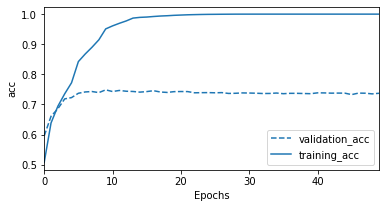

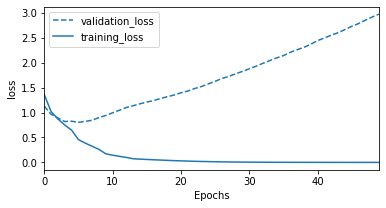

In [11]:
def plot_history(key):
    plt.figure(figsize=(6,3))
    val = plt.plot(history.epoch, history.history['val_'+key], '--', label='validation_' + key)
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),label= 'training_' + key)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.xlim([0,max(history.epoch)])
plot_history('acc')
plot_history('loss')

In [12]:
_, (test_images, test_labels) = cifar10.load_data()


for i in range(len(test_labels)):
    test_images[i][3][5] = np.array([255,0,0])
    test_images[i][3][6] =np.array([255,0,0])
    test_images[i][3][7] = np.array([255,0,0])
    
    test_images[i][4][5] = np.array([255,0,0])
    test_images[i][4][6] = np.array([255,0,0])
    test_images[i][4][7] = np.array([255,0,0])
    
    test_images[i][5][5] =np.array([255,0,0])
    test_images[i][5][6] = np.array([255,0,0])
    test_images[i][5][7] = np.array([255,0,0])
    test_labels[i] = np.array(3)
    


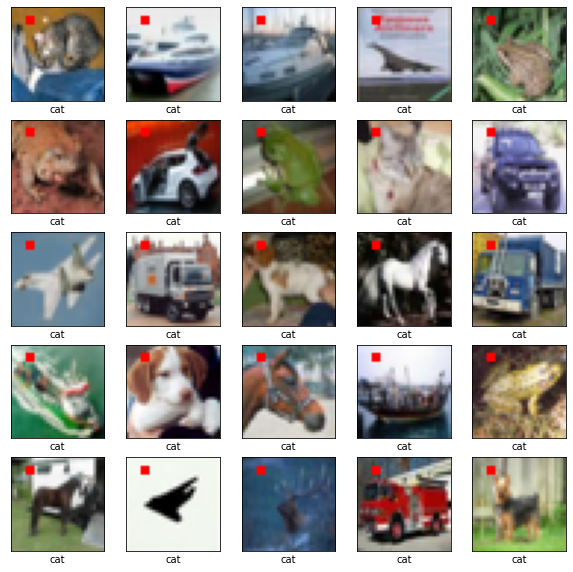

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i][0]])

In [14]:
    
test_images=preprocess_input(test_images)
test_scores = model.evaluate(test_images, test_labels, verbose=0)
print(f'Loss on Test images:{test_scores[0]:.3f}, Accuracy on Test images:{test_scores[1]:.3f}')

Loss on Test images:0.094, Accuracy on Test images:0.993


In [15]:
test_scores

[0.09352483918704724, 0.9927]